# Содержание

1. [Импорт](#import)
2. [Анализ собранных данных](#data_prep)
3. [Визуализация Отзывов](#viz_feed) 
4. [Фильтрация текста](#text_filter)
  - 4.1. Приведение текста в нижний регистр.
  - 4.2. Удаление пунктуации.
  - 4.3. Удаление stop-words на русском, английском и казахском языках.
  - 4.4. Удаление emoji знаков.
<br>
5. [Облако слов](#cloud)
6. [Построение моделей и их улучшение](#model_crea)
  - 6.1. [Логистическая регрессия.](#log_reg)
  - 6.2. [SVM.](#svm)
  - 6.3. [KNN.](#knn)
<br>
7. [Визуальное сравнение моделей](#viz_dif)
8. [Работа и производительность моделей с новыми отзывами](#model_perfomance)
 - 8.1. [Производительность логистической регрессии](#log_p)
 - 8.2. [Производительность SVM](#svm_p)
 - 8.3. [Производительность KNN](#knn_p)
9. [Инсайты](#insights)
10. [Заключение](#end)

## Проект: Сентиментальный Анализ отзывов пользователей с использованием NLP и машинного обучения

<a id='import'></a>
# Импорт Библиотек:

In [286]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from collections import Counter

import re
import string

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

<a id='data_prep'></a>
# Анализ Собранных Данных:

In [128]:
NLP_dataset = pd.read_csv('sentimental analysis.csv')
NLP_dataset.head(20)

,status,text
0,1,"Отличная пешеходная дорога вдоль речки, чистый..."
1,1,"Прекрасное место как для прогулок, так и для з..."
2,1,Замечательная пешеходная дорожка вдоль малой А...
3,1,"Мне нравится там гулять как раз живу рядом,мож..."
4,1,Парк Терренкур простирается вдоль Малой Алмати...
5,1,"Потрясающее место для прогулки как в одиночку,..."
6,1,"Место где можно собраться с мыслями,с друзьями..."
7,1,"Одно из немногих мест в городе, где можно прог..."
8,1,Идеально для пеших прогулок и пробежек. Нужно ...
9,1,Практически каждый день гуляю здесь. Чистенько...


In [129]:
NLP_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   status  222 non-null    int64 
 1   text    222 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.6+ KB


In [130]:
NLP_dataset.describe()

,status
count,222.000000
mean,0.783784
std,0.412594
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [131]:
NLP_dataset ['text']

0      Отличная пешеходная дорога вдоль речки, чистый...
1      Прекрасное место как для прогулок, так и для з...
2      Замечательная пешеходная дорожка вдоль малой А...
3      Мне нравится там гулять как раз живу рядом,мож...
4      Парк Терренкур простирается вдоль Малой Алмати...
                             ...                        
217    Замечательное место для прогулок. В жару прият...
218    Кто нибудь скажите, можно пикник делать? Есть ...
219        Шикарное место для отдыха, все такое красивое
220                              Безумно красивое место😍
221                    Очень красивое место для прогулок
Name: text, Length: 222, dtype: object

# Добавление Колонны "ДЛИНА" Отзыва:

In [132]:
NLP_dataset['length'] = NLP_dataset['text'].apply(len)
NLP_dataset.head(20)

,status,text,length
0,1,"Отличная пешеходная дорога вдоль речки, чистый...",396
1,1,"Прекрасное место как для прогулок, так и для з...",238
2,1,Замечательная пешеходная дорожка вдоль малой А...,345
3,1,"Мне нравится там гулять как раз живу рядом,мож...",215
4,1,Парк Терренкур простирается вдоль Малой Алмати...,375
5,1,"Потрясающее место для прогулки как в одиночку,...",162
6,1,"Место где можно собраться с мыслями,с друзьями...",195
7,1,"Одно из немногих мест в городе, где можно прог...",156
8,1,Идеально для пеших прогулок и пробежек. Нужно ...,154
9,1,Практически каждый день гуляю здесь. Чистенько...,155


In [133]:
NLP_dataset.describe()

,status,length
count,222.000000,222.000000
mean,0.783784,121.292793
std,0.412594,99.150783
min,0.000000,6.000000
25%,1.000000,40.250000
50%,1.000000,97.000000
75%,1.000000,170.000000
max,1.000000,536.000000


# Разделение Отзывов на Положительные (1) и Отрицательные (0):

In [136]:
positive = NLP_dataset[NLP_dataset['status']==1]
negative = NLP_dataset[NLP_dataset['status']==0]

In [137]:
positive.head(20)

,status,text,length
0,1,"Отличная пешеходная дорога вдоль речки, чистый...",396
1,1,"Прекрасное место как для прогулок, так и для з...",238
2,1,Замечательная пешеходная дорожка вдоль малой А...,345
3,1,"Мне нравится там гулять как раз живу рядом,мож...",215
4,1,Парк Терренкур простирается вдоль Малой Алмати...,375
5,1,"Потрясающее место для прогулки как в одиночку,...",162
6,1,"Место где можно собраться с мыслями,с друзьями...",195
7,1,"Одно из немногих мест в городе, где можно прог...",156
8,1,Идеально для пеших прогулок и пробежек. Нужно ...,154
9,1,Практически каждый день гуляю здесь. Чистенько...,155


In [138]:
positive.describe()

,status,length
count,174.0,174.000000
mean,1.0,125.729885
std,0.0,106.636011
min,1.0,6.000000
25%,1.0,38.000000
50%,1.0,100.500000
75%,1.0,183.500000
max,1.0,536.000000


In [139]:
negative.head(20)

,status,text,length
22,0,"Два туалет на всем пути, и те убитые. Само мес...",178
50,0,Слишком много богатых людей,27
51,0,Кто знает есть там рыба и можно ли ловить??,43
52,0,"Great location, terrible service from waiters,...",161
53,0,очень красиво 😻,15
54,0,Что за ужасный запах напротив садика ?,38
55,0,Уточки. Страдают. Помогите им.,30
56,0,"Много слышала про Терренкур , решила посетить,...",301
57,0,СЛУШАЙТЕ АКИМАТ МЕДЕУСКОГО РАЙОНА ЭКОНОМИТ НА ...,237
58,0,"Сплошные машины, велосипеды и скутеры, спокойн...",140


In [140]:
negative.describe()

,status,length
count,48.0,48.000000
mean,0.0,105.208333
std,0.0,63.506729
min,0.0,15.000000
25%,0.0,70.750000
50%,0.0,96.500000
75%,0.0,128.000000
max,0.0,301.000000


Исходя из анализа положительных и отрицательных отзывов, можно сделать следующие выводы:

1. Количество отзывов: Положительных отзывов (174) гораздо больше, чем отрицательных (48). Это может указывать на то, что большинство пользователей оставляют положительные отзывы о месте.<br>
2. Средняя длина отзывов: Средняя длина положительных отзывов (125 символов) чуть выше, чем средняя длина отрицательных отзывов (105 символов). Это может указывать на то, что пользователи, оставляющие положительные отзывы, склонны к более детальному описанию своего опыта. <br>
3. Минимальная и максимальная длина отзывов: Минимальная длина отзывов для обеих категорий отличается незначительно, но максимальная длина положительных отзывов (536 символов) немного выше, чем для отрицательных (301 символ).

<a id='viz_feed'></a>
# Визуализация Отзывов:

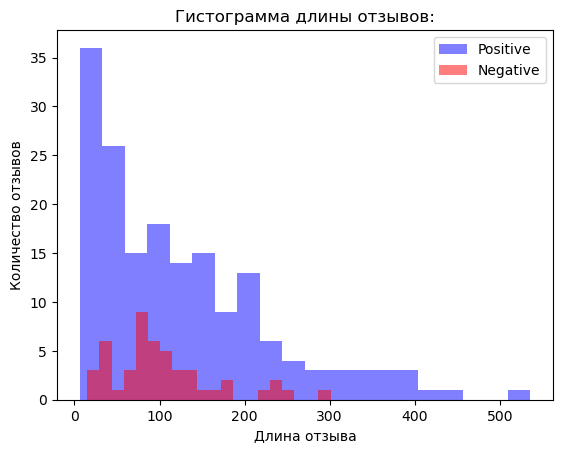

In [141]:
plt.hist(positive['length'], bins=20, color='blue', alpha=0.5, label='Positive')
plt.hist(negative['length'], bins=20, color='red', alpha=0.5, label='Negative')

plt.xlabel('Длина отзыва')
plt.ylabel('Количество отзывов')
plt.title('Гистограмма длины отзывов:')
plt.legend(loc='upper right')
plt.show()

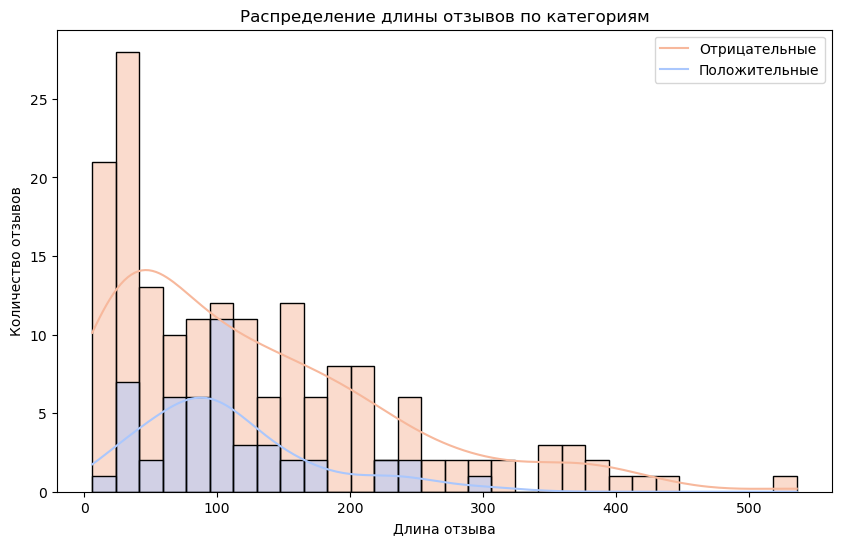

In [142]:
plt.figure(figsize=(10, 6))
sns.histplot(data=NLP_dataset, x='length', hue='status', bins=30, kde=True, palette='coolwarm')
plt.title('Распределение длины отзывов по категориям')
plt.xlabel('Длина отзыва')
plt.ylabel('Количество отзывов')
plt.legend(labels=['Отрицательные', 'Положительные'])
plt.show()

<a id='text_filter'></a>
# Филтрация текста:

#### a. LOWERCASE:

In [143]:
NLP_dataset['text'] = NLP_dataset['text'].apply(lambda x: x.lower())
NLP_dataset.head(1)

,status,text,length
0,1,"отличная пешеходная дорога вдоль речки, чистый...",396


#### b. PUNCTUATION:

In [144]:
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
NLP_dataset['text'] = NLP_dataset['text'].apply(lambda x: x.translate(remove_punct_dict))
NLP_dataset.head(1)

,status,text,length
0,1,отличная пешеходная дорога вдоль речки чистый ...,396


#### c. STOP_WORDS:

In [145]:
NLP_dataset.head(2)

,status,text,length
0,1,отличная пешеходная дорога вдоль речки чистый ...,396
1,1,прекрасное место как для прогулок так и для за...,238


In [146]:
nltk.download('stopwords')

stop_words_en = set(stopwords.words('english'))
stop_words_ru = set(stopwords.words('russian'))
stop_words_kk = set(stopwords.words('kazakh'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_en and 
                                                  word.lower() not in stop_words_ru and
                                                  word.lower() not in stop_words_kk]
    return ' '.join(filtered_words)

NLP_dataset['text'] = NLP_dataset['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [147]:
NLP_dataset.head(2)

,status,text,length
0,1,отличная пешеходная дорога вдоль речки чистый ...,396
1,1,прекрасное место прогулок занятий спортом кажд...,238


#### d. PERFORM COUNT VECTORIZATION (TOKENIZATION)

In [148]:
filtered_text = NLP_dataset['text'].tolist()
print(filtered_text)

['отличная пешеходная дорога вдоль речки чистый воздух максимальная точка подъёма 1060 метров уровнем моря чисто всем протяжении расположены площадки разминки скамьи урны мусора кафе имеется отдельно стоящая огороженая площадка собак специальные дисплеи мешочками сбора экскрементов четвероногих друзей рекомендую пройтись терренкуру возможность', 'прекрасное место прогулок занятий спортом каждым годом терренкур преображается лучшую сторону досаживаются растения прибавляются новые точки отдыха спорта люди атмосфера настоящие алматинские ❤️', 'замечательная пешеходная дорожка вдоль малой алматинки недавно реконструированная приятно посидеть летом тени деревьев шум реки скамейке покачаться качелях позаниматься тренажёрах детям радость поиграть детских площадках зимнее время пройтись пешком совершить пробежку 45км терренкура услугам алмаатинцев', 'нравится гулять живу рядомможно гулять каждый деньзимой кататься склонахно площадка вторая моста большого очень сильно скрепит брусья слишком выс

In [149]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(filtered_text)

tokens = vectorizer.get_feature_names_out()

print("Размерность матрицы признаков (CountVectorizer):", X.shape)
print("\nНекоторые токены:", tokens[:222])

Размерность матрицы признаков (CountVectorizer): (222, 1440)

Некоторые токены: ['01072023г' '1058' '1060' '12' '1900' '23' '2гис' '400' '45' '45км' '55'
 '8000' '876' 'almaty' 'arrive' 'ask' 'beautiful' 'food' 'fork' 'gorgeous'
 'great' 'hr' 'knife' 'leaves' 'location' 'love' 'one' 'peaceful' 'poor'
 'ps' 'quality' 'service' 'several' 'terrible' 'times' 'waiters' 'аб'
 'абсолютная' 'абстрагироваться' 'австралии' 'автомобиля' 'адекватной'
 'акимат' 'акимата' 'аккуратная' 'аллеи' 'аллене' 'аллея' 'алмаатинцев'
 'алмае' 'алмай' 'алмате' 'алматинец' 'алматинка' 'алматинки' 'алматинкой'
 'алматинские' 'алматинского' 'алматы' 'альфараби' 'амангелды' 'аргамаках'
 'асфальтосвещениеесть' 'атмосфера' 'атмосферная' 'атмосферное'
 'атмосферу' 'ауетентичный' 'базар' 'баки' 'баранам' 'баскетбола' 'бега'
 'бегуны' 'бедные' 'беззаботная' 'беззаботное' 'безопаснее' 'безопасно'
 'безопасное' 'безопасность' 'безумно' 'белого' 'белочек' 'берега'
 'беречь' 'беседка' 'беседки' 'беседы' 'бесплатно' 'бесплат

In [150]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # эмодзи смайликов
                               u"\U0001F300-\U0001F5FF"  # символы и пиктограммы
                               u"\U0001F680-\U0001F6FF"  # символы транспорта и карты
                               u"\U0001F1E0-\U0001F1FF"  # флаги (iOS)
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)
NLP_dataset['text'] = NLP_dataset['text'].apply(remove_emoji)

# Данные После Выполнения Всех Филтраций:

In [151]:
NLP_dataset.head(20)

,status,text,length
0,1,отличная пешеходная дорога вдоль речки чистый ...,396
1,1,прекрасное место прогулок занятий спортом кажд...,238
2,1,замечательная пешеходная дорожка вдоль малой а...,345
3,1,нравится гулять живу рядомможно гулять каждый ...,215
4,1,парк терренкур простирается вдоль малой алмати...,375
5,1,потрясающее место прогулки одиночку семьёй ком...,162
6,1,место собраться мыслямис друзьями просто отдох...,195
7,1,одно немногих мест городе прогуляться отдохнут...,156
8,1,идеально пеших прогулок пробежек нужно отдать ...,154
9,1,практически каждый день гуляю чистенько приход...,155


<a id='cloud'></a>
# Облако Слов для обновленных данных:

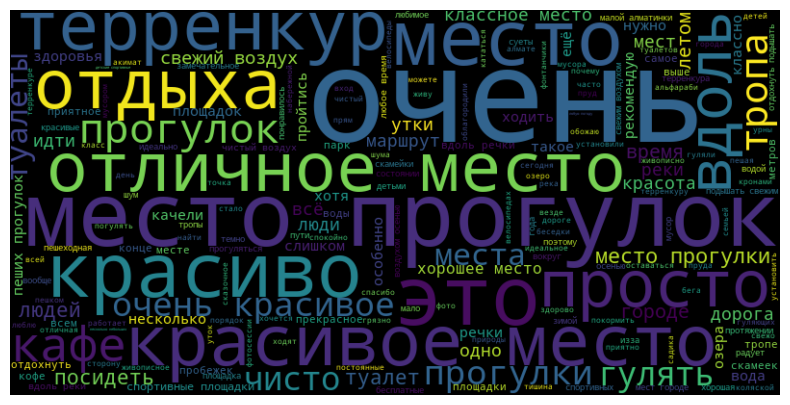

In [152]:
all_text = ' '.join(NLP_dataset['text'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Облаков слов для Положительных отзывов:

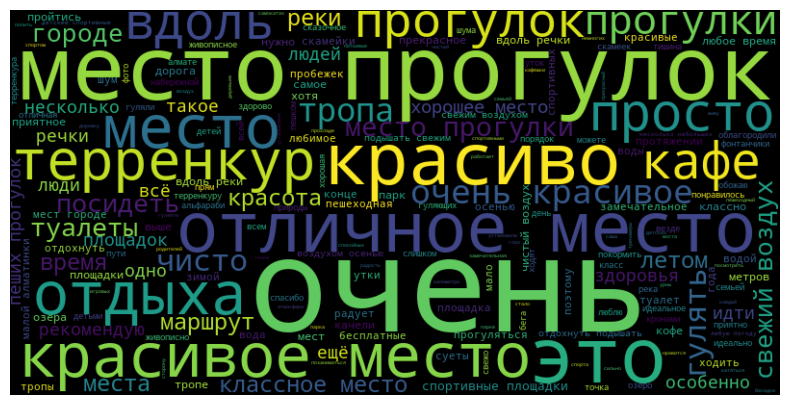

In [153]:
positive_reviews = NLP_dataset[NLP_dataset['status'] == 1]['text']
positive_text = ' '.join(positive_reviews)
wordcloud_positive = WordCloud(width=800, height=400, background_color='black').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.show()

In [154]:
wordcloud = WordCloud()
wordcloud.generate(positive_text)
positive_word_list = list(wordcloud.words_.keys())
print("Позитивные слова:")
print(positive_word_list[:25])

Позитивные слова:
['очень', 'место прогулок', 'это', 'красиво', 'отличное место', 'красивое место', 'место', 'отдыха', 'терренкур', 'просто', 'вдоль', 'кафе', 'прогулок', 'прогулки', 'очень красивое', 'тропа', 'чисто', 'гулять', 'место прогулки', 'посидеть', 'туалеты', 'городе', 'свежий воздух', 'летом', 'реки']


# Облаков слов для Негативных отзывов:

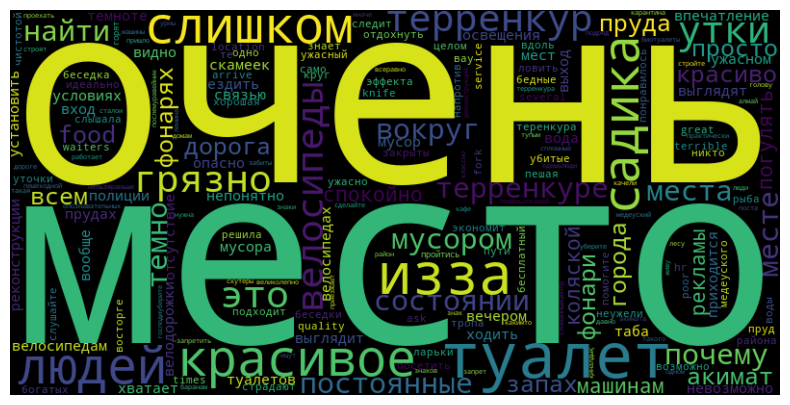

In [155]:
negative_reviews = NLP_dataset[NLP_dataset['status'] == 0]['text']
negative_text = ' '.join(negative_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.show()

In [156]:
wordcloud = WordCloud()
wordcloud.generate(negative_text)
negative_word_list = list(wordcloud.words_.keys())

print("\nОтрицательные слова:")
print(negative_word_list[:25])


Отрицательные слова:
['место', 'очень', 'туалет', 'изза', 'красивое', 'слишком', 'людей', 'садика', 'терренкур', 'грязно', 'утки', 'это', 'велосипеды', 'терренкуре', 'месте', 'темно', 'почему', 'мусором', 'места', 'вокруг', 'состоянии', 'постоянные', 'найти', 'всем', 'дорога']


<a id='model_crea'></a>
# Построение моделей:

<a id='log_reg'></a>
### Логистическая регрессия:

In [157]:
X_train, X_test, y_train, y_test = train_test_split(NLP_dataset['text'], NLP_dataset['status'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_tfidf, y_train)

y_pred_logistic_regression = logistic_regression_model.predict(X_test_tfidf)

accuracy_logistic_regression = accuracy_score(y_test, y_pred_logistic_regression)
report_logistic_regression = classification_report(y_test, y_pred_logistic_regression)

print('Точность Logistic Regression на тестовом наборе:', accuracy_logistic_regression)
print('Отчет о классификации Logistic Regression:')
print(report_logistic_regression)

Точность Logistic Regression на тестовом наборе: 0.7333333333333333
Отчет о классификации Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.73      1.00      0.85        33

    accuracy                           0.73        45
   macro avg       0.37      0.50      0.42        45
weighted avg       0.54      0.73      0.62        45



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Точность модели Logistic Regression на тестовом наборе составила около 73%. Однако, если обратить внимание на отчет о классификации, можно заметить, что модель показывает низкую точность (precision) для класса с отрицательными отзывами (0), а также низкую полноту (recall) и F1-меру. Это может означать, что модель плохо справляется с классификацией отрицательных отзывов. В этом случае количество положительных отзывов (174) значительно превышает количество негативных отзывов (48), что и создает сильный дисбаланс. Для преодоления этой проблемы ниже приведён параметр class_weight='balanced', чтобы автоматически взвесить классы в соответствии с их долей в обучающем наборе данных:

In [158]:
logistic_regression_model_balanced = LogisticRegression(class_weight='balanced')
logistic_regression_model_balanced.fit(X_train_tfidf, y_train)

y_pred_logistic_regression_balanced = logistic_regression_model_balanced.predict(X_test_tfidf)

accuracy_logistic_regression_balanced = accuracy_score(y_test, y_pred_logistic_regression_balanced)
report_logistic_regression_balanced = classification_report(y_test, y_pred_logistic_regression_balanced)

print('Точность Logistic Regression с взвешиванием классов на тестовом наборе:', accuracy_logistic_regression_balanced)
print('Отчет о классификации Logistic Regression с взвешиванием классов:')
print(report_logistic_regression_balanced)

Точность Logistic Regression с взвешиванием классов на тестовом наборе: 0.8888888888888888
Отчет о классификации Logistic Regression с взвешиванием классов:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.89      0.97      0.93        33

    accuracy                           0.89        45
   macro avg       0.89      0.82      0.84        45
weighted avg       0.89      0.89      0.88        45



#### Использование взвешивания классов позволило значительно улучшить производительность модели Logistic Regression на тестовом наборе данных. Теперь точность составляет около 89%, что гораздо лучше, чем ранее.

#### Кроме того, обратите внимание на улучшение метрик precision, recall и F1-score для класса с отрицательными отзывами (0). Теперь точность составляет 0.89, что говорит о том, что большинство отзывов, классифицированных моделью как отрицательные, действительно являются отрицательными. Результаты также показывают хорошую полноту и F1-меру для этого класса.

In [159]:
accuracy_lr = accuracy_score(y_test, y_pred_logistic_regression)
precision_lr = precision_score(y_test, y_pred_logistic_regression)
recall_lr = recall_score(y_test, y_pred_logistic_regression)
f1_lr = f1_score(y_test, y_pred_logistic_regression)

accuracy_lr_balanced = accuracy_score(y_test, y_pred_logistic_regression_balanced)
precision_lr_balanced = precision_score(y_test, y_pred_logistic_regression_balanced)
recall_lr_balanced = recall_score(y_test, y_pred_logistic_regression_balanced)
f1_lr_balanced = f1_score(y_test, y_pred_logistic_regression_balanced)

In [160]:
metrics_comparison = pd.DataFrame({
    'Метрика': ['Точность (Accuracy)', 'Меткость (Precision)', 'Полнота (Recall)', 'F1-мера'],
    'Без взвешивания классов': [accuracy_lr, precision_lr, recall_lr, f1_lr],
    'С взвешиванием классов': [accuracy_lr_balanced, precision_lr_balanced, recall_lr_balanced, f1_lr_balanced]
})

print(metrics_comparison)

                Метрика  Без взвешивания классов  С взвешиванием классов
0   Точность (Accuracy)                 0.733333                0.888889
1  Меткость (Precision)                 0.733333                0.888889
2      Полнота (Recall)                 1.000000                0.969697
3               F1-мера                 0.846154                0.927536


<a id='svm'></a>
### SVM:

In [161]:
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print('Производительность базовой модели SVM:')
print(f'Точность: {accuracy_svm:.4f}')
print(f'Precision: {precision_svm:.4f}')
print(f'Recall: {recall_svm:.4f}')
print(f'F1-мера: {f1_svm:.4f}')

Производительность базовой модели SVM:
Точность: 0.7333
Precision: 0.7333
Recall: 1.0000
F1-мера: 0.8462


#### Значения оказались немного ниже ожидаемых, что может указывать на небольшое количество ложно положительных предсказаний. В целом F1-мера довольно высока, что свидетельствует о хорошем балансе между Precision и Recall. Для улучшения производительности модели ниже приведён пример поискать и применения оптимальных гиперпараметров:

In [162]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

svm_model = SVC()

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print("Лучшие гиперпараметры:")
print(grid_search.best_params_)
print("Точность на кросс-валидации:")
print(grid_search.best_score_)

Лучшие гиперпараметры:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Точность на кросс-валидации:
0.8303174603174603


In [163]:
best_svm_model = SVC(C=100, gamma=0.01, kernel='rbf')

best_svm_model.fit(X_train_tfidf, y_train)

y_pred_best_svm = best_svm_model.predict(X_test_tfidf)

accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm)
precision_best_svm = precision_score(y_test, y_pred_best_svm)
recall_best_svm = recall_score(y_test, y_pred_best_svm)
f1_best_svm = f1_score(y_test, y_pred_best_svm)

print('Производительность модели SVM с оптимальными гиперпараметрами:')
print(f'Точность: {accuracy_best_svm:}')
print(f'Precision: {precision_best_svm:}')
print(f'Recall: {recall_best_svm:}')
print(f'F1-мера: {f1_best_svm:}')

Производительность модели SVM с оптимальными гиперпараметрами:
Точность: 0.8888888888888888
Precision: 0.868421052631579
Recall: 1.0
F1-мера: 0.9295774647887324


#### После настройки гиперпараметров производительность модели SVM значительно улучшилась. Теперь модель обладает высокой точностью, полнотой и F1-мерой, что указывает на ее хорошую способность классифицировать отзывы как положительные или отрицательные.

In [164]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm)
precision_best_svm = precision_score(y_test, y_pred_best_svm)
recall_best_svm = recall_score(y_test, y_pred_best_svm)
f1_best_svm = f1_score(y_test, y_pred_best_svm)

metrics_comparison_svm = pd.DataFrame({
    'Метрика': ['Точность (Accuracy)', 'Меткость (Precision)', 'Полнота (Recall)', 'F1-мера'],
    'Без настройки гиперпараметров': [accuracy_svm, precision_svm, recall_svm, f1_svm],
    'С настройкой гиперпараметров': [accuracy_best_svm, precision_best_svm, recall_best_svm, f1_best_svm]
})

print(metrics_comparison_svm)

                Метрика  Без настройки гиперпараметров  \
0   Точность (Accuracy)                       0.733333   
1  Меткость (Precision)                       0.733333   
2      Полнота (Recall)                       1.000000   
3               F1-мера                       0.846154   

   С настройкой гиперпараметров  
0                      0.888889  
1                      0.868421  
2                      1.000000  
3                      0.929577  


<a id='knn'></a>
### KNN

In [165]:
knn_model = KNeighborsClassifier()

knn_model.fit(X_train_tfidf, y_train)

y_pred_knn = knn_model.predict(X_test_tfidf)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_tfidf, y_train)

best_params_knn = grid_search_knn.best_params_
best_knn_model = KNeighborsClassifier(**best_params_knn)
best_knn_model.fit(X_train_tfidf, y_train)


y_pred_best_knn = best_knn_model.predict(X_test_tfidf)

accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
precision_best_knn = precision_score(y_test, y_pred_best_knn)
recall_best_knn = recall_score(y_test, y_pred_best_knn)
f1_best_knn = f1_score(y_test, y_pred_best_knn)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\user\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\user\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\user\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\user\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.w

In [166]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
precision_best_knn = precision_score(y_test, y_pred_best_knn)
recall_best_knn = recall_score(y_test, y_pred_best_knn)
f1_best_knn = f1_score(y_test, y_pred_best_knn)

metrics_comparison_knn = pd.DataFrame({
    'Метрика': ['Точность (Accuracy)', 'Меткость (Precision)', 'Полнота (Recall)', 'F1-мера'],
    'Без настройки гиперпараметров': [accuracy_knn, precision_knn, recall_knn, f1_knn],
    'С настройкой гиперпараметров': [accuracy_best_knn, precision_best_knn, recall_best_knn, f1_best_knn]
})

print(metrics_comparison_knn)

                Метрика  Без настройки гиперпараметров  \
0   Точность (Accuracy)                       0.800000   
1  Меткость (Precision)                       0.785714   
2      Полнота (Recall)                       1.000000   
3               F1-мера                       0.880000   

   С настройкой гиперпараметров  
0                      0.822222  
1                      0.820513  
2                      0.969697  
3                      0.888889  


#### Модель KNN показывает хорошую точность (Accuracy) и меткость (Precision) без настройки гиперпараметров, однако ее полнота (Recall) немного ниже по сравнению с другими моделями. Это может означать, что KNN склонен к более консервативным предсказаниям, когда решает отнести объект к положительному классу. С настройкой гиперпараметров полнота немного улучшилась, но все еще остается ниже, чем у других моделей. F1-мера также находится на уровне других моделей после настройки гиперпараметров.

<a id='viz_dif'></a>
# Визуальное сравнение и выбор лучшей модели:

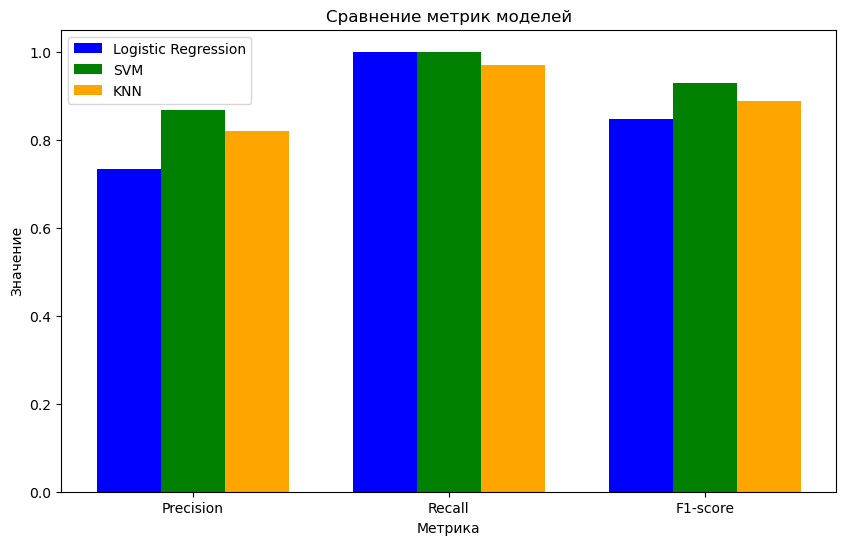

In [167]:
metrics_lr = [precision_lr, recall_lr, f1_lr]
metrics_svm = [precision_best_svm, recall_best_svm, f1_best_svm]
metrics_knn = [precision_best_knn, recall_best_knn, f1_best_knn]

metric_labels = ['Precision', 'Recall', 'F1-score']

bar_positions = np.arange(len(metric_labels))

bar_width = 0.25

plt.figure(figsize=(10, 6))

plt.bar(bar_positions - bar_width, metrics_lr, bar_width, label='Logistic Regression', color='blue')
plt.bar(bar_positions, metrics_svm, bar_width, label='SVM', color='green')
plt.bar(bar_positions + bar_width, metrics_knn, bar_width, label='KNN', color='orange')

plt.xticks(bar_positions, metric_labels)

plt.legend()

plt.title('Сравнение метрик моделей')
plt.xlabel('Метрика')
plt.ylabel('Значение')

plt.show()

#### Исходя из представленных метрик, SVM и LogisticRegression показывают лучшие результат по всем показателям Precision, Recall и F1-score. Таким образом, SVM и LogisticRegression можно считать лучшими моделями среди рассмотренных.

<a id='model_perfomance'></a>
# Работа Моделей с новыми отзывами:

<a id='log_p'></a>
#### Работа Логистической регресии:

In [282]:
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('russian')])
    return text

new_review = input("Введите ваш отзыв: ")
new_review = preprocess_text(new_review)
new_review_tfidf = tfidf_vectorizer.transform([new_review])
prediction_lr = logistic_regression_model_balanced.predict(new_review_tfidf)

if prediction_lr[0] == 1:
    print("Отзыв положительный.")
else:
    print("Отзыв отрицательный.")

Введите ваш отзыв: Живу здесь очень давно, до реконструкции так классно было, на велосипедах можно было ездить 😠 на ленина едешь-люди, на терренкуре людей очень много тоже, так еще и запрет, в одном месте можно ходить или нет???! уберите знаки или сделайте велодорожки !
Отзыв отрицательный.


<a id='svm_p'></a>
#### Работа SVM:

In [283]:
def preprocess_text(text):
    text = text.lower()  
    text = ''.join([char for char in text if char not in string.punctuation])  
    text = ' '.join([word for word in text.split() if word not in stopwords.words('russian')])  
    return text

new_review = input("Введите ваш отзыв: ")
preprocessed_review = preprocess_text(new_review)

new_review_tfidf_svm = tfidf_vectorizer.transform([preprocessed_review])
prediction_svm = best_svm_model.predict(new_review_tfidf_svm)

if prediction_svm[0] == 1:
    print("Отзыв положительный.")
else:
    print("Отзыв отрицательный.")

Введите ваш отзыв: Живу здесь очень давно, до реконструкции так классно было, на велосипедах можно было ездить 😠 на ленина едешь-люди, на терренкуре людей очень много тоже, так еще и запрет, в одном месте можно ходить или нет???! уберите знаки или сделайте велодорожки !
Отзыв положительный.


<a id='knn_p'></a>
#### Работа KNN:

In [284]:
def preprocess_text(text):
    text = text.lower()  
    text = ''.join([char for char in text if char not in string.punctuation])  
    text = ' '.join([word for word in text.split() if word not in stopwords.words('russian')])  
    return text

new_review = input("Введите ваш отзыв: ")
preprocessed_review = preprocess_text(new_review)

new_review_tfidf_knn = tfidf_vectorizer.transform([preprocessed_review])
prediction_knn = best_knn_model.predict(new_review_tfidf_knn)

if prediction_knn[0] == 1:
    print("Отзыв положительный.")
else:
    print("Отзыв отрицательный.")

Введите ваш отзыв: Живу здесь очень давно, до реконструкции так классно было, на велосипедах можно было ездить 😠 на ленина едешь-люди, на терренкуре людей очень много тоже, так еще и запрет, в одном месте можно ходить или нет???! уберите знаки или сделайте велодорожки !
Отзыв отрицательный.


<a id='insights'></a>
# Инсайты:

In [285]:
all_words = ' '.join(NLP_dataset['text']).split()
word_counts = Counter(all_words)
most_common_word = word_counts.most_common(1)[0][0]
most_common_word_count = word_counts.most_common(1)[0][1]

print("Самое часто встречающееся слово:", most_common_word)
print("Количество упоминаний:", most_common_word_count)

Самое часто встречающееся слово: место
Количество упоминаний: 110


In [289]:
rarest_word = word_counts.most_common()[-1][0]
rarest_word_count = word_counts.most_common()[-1][1]

print("Самое редковстречающееся слово:", rarest_word)
print("Количество упоминаний:", rarest_word_count)

Самое редковстречающееся слово: делать
Количество упоминаний: 1


In [287]:
NLP_dataset[NLP_dataset['length'] == 6]['text'].iloc[0]

'ништяк'

In [288]:
NLP_dataset[NLP_dataset['length'] == 536]['text'].iloc[0]

'потрясающе уединенное место прогулки журчащая вода аккуратная тропа реновации чистый воздух сравнительно городом деревья высокими кронами плотной листвой отличный сказывается самочувствии удобные скамейки качели игровые площадки детей некоторых местах точки перекуса кофе прогулку начать пересечении улиц достық оспанова удобнее спускаться подниматься сторону гор заканчивается терренкур дворец республики однозначная рекомендация ради профилактики здоровья'

In [290]:
average_length = np.mean([len(review.split()) for review in NLP_dataset['text']])
print("Средняя длина отзывов:", average_length)

Средняя длина отзывов: 12.378378378378379


In [295]:
average_word_length = np.mean([len(word) for review in NLP_dataset['text'] for word in review.split()])
print("Средняя длина слова:", average_word_length)

Средняя длина слова: 6.9341339155749635


In [296]:
unique_words_count = len(set(all_words))
print("Число уникальных слов:", unique_words_count)

Число уникальных слов: 1455


In [298]:
reviews_by_category = NLP_dataset.groupby('status').size()
print("Число отзывов по категориям:")
print(reviews_by_category)

Число отзывов по категориям:
status
0     48
1    174
dtype: int64


<a id='end'></a>
#### Заключение
В ходе данного проекта был выполнен анализ отзывов пользователей с использованием методов обработки естественного языка (NLP) и машинного обучения. <br>

- Сначала данные были собраны вручную из источников 2gis и Yandex. Всего было собрано 222 отзыва.<br>
- Затем данные были предобработаны: тексты были переведены в нижний регистр, удалена пунктуация, стоп-слова и emoji. Также была добавлена колонка с длиной отзывов. <br>
- Проведен анализ данных, включая визуализацию распределения длин отзывов. <br>
- Выполнена векторизация текстов с использованием методов CountVectorizer и TfidfVectorizer. <br>
- Построены модели машинного обучения: логистическая регрессия, метод опорных векторов (SVM) и метод k-ближайших соседей (KNN). Каждая модель была улучшена с помощью настройки гиперпараметров и балансировки классов. <br>
- Проведено сравнение производительности моделей и выбор лучшей модели на основе метрик точности, меткости, полноты и F1-меры. <br>
- Проверена работа моделей на новых отзывах, введенных пользователем через консольный ввод.<br>
- Выполнен анализ инсайтов, таких как самый длинный и короткий отзывы, самые часто и редко встречающиеся слова. <br>

В целом, проект позволил провести анализ и классификацию отзывов пользователей с использованием различных методов обработки текстов и машинного обучения. Полученные модели могут быть использованы для автоматической оценки и анализа отзывов на основе их содержания.